# Логистическая регрессия — Notebook для `Doctor.xlsx`

Задачи:
- Описательная статистика (`summary`), создание категориальных факторов при необходимости;
- Базовая логит-модель (`glm` с биномиальной семьёй), уравнение регрессии;
- Тесты значимости коэффициентов (Wald / z), тест значимости модели (Likelihood Ratio и Wald);
- Доверительные интервалы (confint и вручную), сравнение Logit vs Probit;
- Confusion matrix (порог 0.5), sensitivity / specificity, поиск оптимального порога (Youden index);
- (Опционально) разбиение на train/test, ROC-кривая и AUC;
- Stepwise selection по AIC (stepAIC аналог).

Все переменные/функции в camelCase. Код сопровождается комментариями и интерпретациями.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sps

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix

plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['font.size'] = 11
sns.set_theme(style='whitegrid')


## 1. Загрузка данных и предобработка

In [2]:
doctorDataFrame = pd.read_excel('../datasets/Doctor.xlsx')
display(doctorDataFrame.head())

def toFloatFromCommaSafe(x):
    try:
        if pd.isna(x):
            return np.nan
        s = str(x).strip().replace(',', '.')
        return float(s)
    except:
        return np.nan

for col in doctorDataFrame.columns:
    if col != 'y':
        doctorDataFrame[col] = doctorDataFrame[col].apply(toFloatFromCommaSafe)

doctorDataFrame['y'] = doctorDataFrame['y'].astype(int)

print('Размер данных:', doctorDataFrame.shape)
doctorDataFrame.info()

,y,x1,x2,x3,x4,x5
0,0,14,4.30,1.00,2,3.72
1,0,12,11.54,8.49,3,40.28
2,0,14,5.84,2.47,3,56.00
3,1,11,14.70,6.60,1,57.41
4,0,21,5.10,3.48,1,83.00


Размер данных: (58, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       58 non-null     int32  
 1   x1      58 non-null     float64
 2   x2      58 non-null     float64
 3   x3      58 non-null     float64
 4   x4      58 non-null     float64
 5   x5      58 non-null     float64
dtypes: float64(5), int32(1)
memory usage: 2.6 KB


## 2. Описательная статистика (`summary`)

In [3]:
display(doctorDataFrame.describe(include='all'))

print('\nCounts of y:')
print(doctorDataFrame['y'].value_counts())


,y,x1,x2,x3,x4,x5
count,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000
mean,0.637931,16.327586,10.327931,7.141379,2.344828,45.135000
std,0.484796,3.213939,3.957742,3.749343,0.928151,53.956171
min,0.000000,11.000000,3.300000,1.000000,1.000000,0.800000
25%,0.000000,14.000000,6.375000,3.985000,1.000000,22.115000
50%,1.000000,16.000000,10.450000,6.835000,3.000000,38.935000
75%,1.000000,19.000000,13.400000,9.975000,3.000000,53.125000
max,1.000000,27.000000,19.000000,16.000000,3.000000,399.800000



Counts of y:
1    37
0    21
Name: y, dtype: int64


## 3. Создание категориальной переменной (factor)

Если какая-то переменная (например, x4) должна быть фактором (категориальной), конвертируем её в `category` и при необходимости создаём дамми-переменные.


In [4]:
doctorDataFrame['x4_cat'] = doctorDataFrame['x4'].astype('category')
print('x4 unique categories:', doctorDataFrame['x4_cat'].cat.categories)
display(doctorDataFrame[['x4','x4_cat']].head())

x4 unique categories: Float64Index([1.0, 2.0, 3.0], dtype='float64')


,x4,x4_cat
0,2.0,2.0
1,3.0,3.0
2,3.0,3.0
3,1.0,1.0
4,1.0,1.0


## 4. Базовая логит-модель (glm с биномиальной семьёй)

Модель с максимально возможным количеством предикторов (включая категориальные через C()).

In [5]:
# Сформируем формулу: y ~ x1 + x2 + x3 + x5 + x4_cat
predictorTerms = []
for col in ['x1','x2','x3','x5']:
    if col in doctorDataFrame.columns:
        predictorTerms.append(col)
predictorTerms.append('C(x4_cat)')

formula = 'y ~ ' + ' + '.join(predictorTerms)
print('Formula:', formula)

# Fit GLM (Binomial = logistic)
glmLogitModel = smf.glm(formula=formula, data=doctorDataFrame, family=sm.families.Binomial()).fit()
print('--- GLM (Logit) summary ---')
print(glmLogitModel.summary())

Formula: y ~ x1 + x2 + x3 + x5 + C(x4_cat)
--- GLM (Logit) summary ---
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                   58
Model:                            GLM   Df Residuals:                       51
Model Family:                Binomial   Df Model:                            6
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -19.625
Date:                Wed, 29 Oct 2025   Deviance:                       39.251
Time:                        23:07:45   Pearson chi2:                     48.4
No. Iterations:                     6   Pseudo R-squ. (CS):             0.4687
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------

## 5. Уравнение бинарной регрессии (логит)
Запишем в явном виде logit(p) = beta0 + beta1*x1 + ... и покажем коэффициенты.

In [6]:
coefficientsLogit = glmLogitModel.params
print('Coefficients (logit):')
display(coefficientsLogit)

interceptLogit = coefficientsLogit.get('Intercept', coefficientsLogit.get('const', None))
termsLogit = []
for name, coef in coefficientsLogit.items():
    termsLogit.append(f'({coef:.4f})*{name}')
equationLogit = 'logit(p) = ' + ' + '.join(termsLogit)
print('\nRegression equation (logit scale):')
print(equationLogit)
print('\nProbability form: p = 1 / (1 + exp(-linear_predictor))')


Coefficients (logit):


Intercept          -10.700949
C(x4_cat)[T.2.0]    -2.146184
C(x4_cat)[T.3.0]     0.226385
x1                   0.459591
x2                   0.818263
x3                  -0.378967
x5                  -0.033825
dtype: float64


Regression equation (logit scale):
logit(p) = (-10.7009)*Intercept + (-2.1462)*C(x4_cat)[T.2.0] + (0.2264)*C(x4_cat)[T.3.0] + (0.4596)*x1 + (0.8183)*x2 + (-0.3790)*x3 + (-0.0338)*x5

Probability form: p = 1 / (1 + exp(-linear_predictor))


## 6. Тест значимости коэффициентов по отдельности (Wald / z-test)

Для GLM стандартный вывод содержит `z` (Wald) и p-values; выведем статистики явно.

In [7]:
coefEstimate = glmLogitModel.params
coefStdErr = glmLogitModel.bse
zValues = coefEstimate / coefStdErr
pValues = 2 * (1 - sps.norm.cdf(np.abs(zValues)))

resultTable = pd.DataFrame({
    'coef': coefEstimate,
    'stdErr': coefStdErr,
    'z': zValues,
    'pValue': pValues
})
print('Wald z-test for coefficients:')
display(resultTable)

Wald z-test for coefficients:


,coef,stdErr,z,pValue
Intercept,-10.700949,3.699734,-2.892356,0.003824
C(x4_cat)[T.2.0],-2.146184,4.144466,-0.517843,0.604568
C(x4_cat)[T.3.0],0.226385,0.844126,0.268189,0.788554
x1,0.459591,0.177050,2.595824,0.009436
x2,0.818263,0.436464,1.874754,0.060827
x3,-0.378967,0.421248,-0.899628,0.368318
x5,-0.033825,0.020453,-1.653818,0.098164


In [8]:
coeffIndex = glmLogitModel.params.index.tolist()
numCoeffs = len(coeffIndex)

waldResults = []
for i, coefName in enumerate(coeffIndex):
    # R матрица (1 x k): тест H0: beta_i = 0
    R = np.zeros((1, numCoeffs))
    R[0, i] = 1.0

    waldRes = glmLogitModel.wald_test(R, scalar=True)
    statRaw = waldRes.statistic
    waldStat = float(np.atleast_1d(statRaw).squeeze())
    waldPvalue = float(waldRes.pvalue)
    

    waldResults.append({
        'term': coefName,
        'waldStat_chi2': waldStat,
        'df': 1,
        'pValue': waldPvalue
    })

waldResultsDf = pd.DataFrame(waldResults).set_index('term')
print('Wald test (each coefficient separately):')
display(waldResultsDf)


Wald test (each coefficient separately):


,waldStat_chi2,df,pValue
term,,,
Intercept,8.365725,1,0.003824
C(x4_cat)[T.2.0],0.268162,1,0.604568
C(x4_cat)[T.3.0],0.071925,1,0.788554
x1,6.738303,1,0.009436
x2,3.514704,1,0.060827
x3,0.809330,1,0.368318
x5,2.735114,1,0.098164


## 7. Значимость регрессии в целом

Проверим модель в целом двумя способами:
- Wald test (в статистическом summary есть);  
- Likelihood Ratio Test: сравним модель с нулевой моделью (intercept-only).


In [9]:
# all coefficients = 0 (включая intercept обычно; при желании можно исключить const)
allR = np.eye(numCoeffs)
waldResAll = glmLogitModel.wald_test(allR, scalar=True)

statAllRaw = waldResAll.statistic
waldStatAll = float(np.atleast_1d(statAllRaw).squeeze())
dfAll = allR.shape[0]
waldPvalueAll = float(waldResAll.pvalue)
print('Wald test (all coefficients simultaneously):')
print(f'Chi2 stat = {waldStatAll:.6f}, df = {dfAll}, p-value = {waldPvalueAll:.6g}')


# Wald statistic (в statsmodels есть поле 'deviance' и 'null_deviance') — можно посмотреть deviance reduction
nullDeviance = glmLogitModel.null_deviance
modelDeviance = glmLogitModel.deviance
devianceDiff = nullDeviance - modelDeviance
dfDiff = glmLogitModel.df_model
pValueDeviance = 1 - sps.chi2.cdf(devianceDiff, dfDiff)
print('\nDeviance null =', nullDeviance)
print('Deviance model =', modelDeviance)
print('Deviance reduction =', devianceDiff, ', df =', dfDiff, ', p-value =', pValueDeviance)

# LR test explicitly: compare log-likelihoods with intercept-only model
yVec = doctorDataFrame['y']
XIntercept = sm.add_constant(pd.DataFrame({'const': np.ones(len(doctorDataFrame))}))
nullModel = sm.GLM(yVec, XIntercept, family=sm.families.Binomial()).fit()
llfReduced = nullModel.llf
llfFull = glmLogitModel.llf
lrStat = 2 * (llfFull - llfReduced)
lrDf = glmLogitModel.df_model
lrPvalue = 1 - sps.chi2.cdf(lrStat, lrDf)
print(f'\nLLF full  = {llfFull:.6f}')
print(f'LLF null  = {llfReduced:.6f}')
print(f'LR stat   = {lrStat:.6f}')
print(f'df diff   = {dfDiff}')
print(f'LR p-value= {lrPvalue:.6e}')

Wald test (all coefficients simultaneously):
Chi2 stat = 13.512737, df = 7, p-value = 0.0605583

Deviance null = 75.93352130332826
Deviance model = 39.25078387094586
Deviance reduction = 36.6827374323824 , df = 6 , p-value = 2.030245610518122e-06

LLF full  = -19.625392
LLF null  = -37.966761
LR stat   = 36.682737
df diff   = 6
LR p-value= 2.030246e-06


## 8. Доверительные интервалы для коэффициентов регрессии

- `confint()` — стандартные (Wald) интервалы из statsmodels;  
- `confint_default` — построим вручную как coef ± z*se (обычно совпадает с confint для GLM).

In [10]:
ciWald = glmLogitModel.conf_int(alpha=0.05)
ciWald.columns = ['ciLower','ciUpper']
ciManualLower = coefEstimate - 1.96 * coefStdErr
ciManualUpper = coefEstimate + 1.96 * coefStdErr
ciManual = pd.DataFrame({'ciManualLower': ciManualLower, 'ciManualUpper': ciManualUpper})
print('confint (Wald) from model:')
display(ciWald)
print('\nManual approx (coef ± 1.96*se):')
display(ciManual)


confint (Wald) from model:


,ciLower,ciUpper
Intercept,-17.952294,-3.449604
C(x4_cat)[T.2.0],-10.269187,5.976819
C(x4_cat)[T.3.0],-1.428071,1.880841
x1,0.112579,0.806603
x2,-0.037191,1.673716
x3,-1.204598,0.446665
x5,-0.073912,0.006262



Manual approx (coef ± 1.96*se):


,ciManualLower,ciManualUpper
Intercept,-17.952427,-3.449470
C(x4_cat)[T.2.0],-10.269337,5.976969
C(x4_cat)[T.3.0],-1.428102,1.880872
x1,0.112573,0.806610
x2,-0.037207,1.673732
x3,-1.204613,0.446680
x5,-0.073913,0.006262


## 9. Сравнение Logit vs Probit

Построим Probit (GLM с link=probit) и сравним AIC / логарифмы правдоподобия / прогнозы.

In [11]:
glmProbitModel = smf.glm(formula=formula, data=doctorDataFrame, family=sm.families.Binomial(link=sm.families.links.Probit())).fit()
print('--- Probit summary ---')
print(glmProbitModel.summary())

print('\nComparison:')
print('Logit AIC =', glmLogitModel.aic, ', Probit AIC =', glmProbitModel.aic)
print('Logit llf =', glmLogitModel.llf, ', Probit llf =', glmProbitModel.llf)


--- Probit summary ---
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                   58
Model:                            GLM   Df Residuals:                       51
Model Family:                Binomial   Df Model:                            6
Link Function:                 Probit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -19.620
Date:                Wed, 29 Oct 2025   Deviance:                       39.239
Time:                        23:07:45   Pearson chi2:                     45.9
No. Iterations:                     8   Pseudo R-squ. (CS):             0.4688
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept        

## 10. Confusion matrix при пороге 0.5, sensitivity и specificity

Напишем вспомогательные функции для матрицы и метрик.

In [12]:
def confusionMatrixFromPreds(yTrue, probPred, threshold=0.5):
    yPred = (probPred >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(yTrue, yPred).ravel()
    cmDf = pd.DataFrame([[tn, fp],[fn, tp]], index=['Actual0','Actual1'], columns=['Pred0','Pred1'])
    sensitivity = tp / (tp + fn) if (tp + fn)>0 else np.nan
    specificity = tn / (tn + fp) if (tn + fp)>0 else np.nan
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    return cmDf, sensitivity, specificity, accuracy

probPredLogit = glmLogitModel.predict(doctorDataFrame)

cm50, sens50, spec50, acc50 = confusionMatrixFromPreds(doctorDataFrame['y'].values, probPredLogit, threshold=0.5)
print('Confusion matrix (threshold=0.5):')
display(cm50)
print('\nSensitivity =', sens50, ', Specificity =', spec50, ', Accuracy =', acc50)

Confusion matrix (threshold=0.5):


,Pred0,Pred1
Actual0,16,5
Actual1,3,34



Sensitivity = 0.918918918918919 , Specificity = 0.7619047619047619 , Accuracy = 0.8620689655172413


## 11. Поиск оптимального порога (Youden index) и матрица для него

Оптимальный порог — максимизирует (sensitivity + specificity - 1).

In [13]:
def findOptimalCutoff(yTrue, probPred):
    fpr, tpr, thresholds = roc_curve(yTrue, probPred)
    youdenIndex = tpr - fpr
    bestIdx = np.argmax(youdenIndex)
    bestThreshold = thresholds[bestIdx]
    bestSens = tpr[bestIdx]
    bestSpec = 1 - fpr[bestIdx]
    return bestThreshold, bestSens, bestSpec, bestIdx

bestThr, bestSens, bestSpec, bestIdx = findOptimalCutoff(doctorDataFrame['y'].values, probPredLogit)
print('Optimal threshold (Youden) =', bestThr)
print('Sensitivity =', bestSens, ', Specificity =', bestSpec)

cmOptimal, sensOpt, specOpt, accOpt = confusionMatrixFromPreds(doctorDataFrame['y'].values, probPredLogit, threshold=bestThr)
print('\nConfusion matrix (optimal threshold):')
display(cmOptimal)
print('\nAccuracy =', accOpt)

Optimal threshold (Youden) = 0.5717812373248472
Sensitivity = 0.918918918918919 , Specificity = 0.8571428571428572

Confusion matrix (optimal threshold):


,Pred0,Pred1
Actual0,18,3
Actual1,3,34



Accuracy = 0.896551724137931


## 12. Разбиение выборки на train/test (опционально) и ROC кривая

Если выборка большая, полезно оценивать модель на тестовой выборке. Здесь приведён пример с fraction = 0.7.

Train size = 41 , Test size = 17
Test AUC = 0.8653846153846154


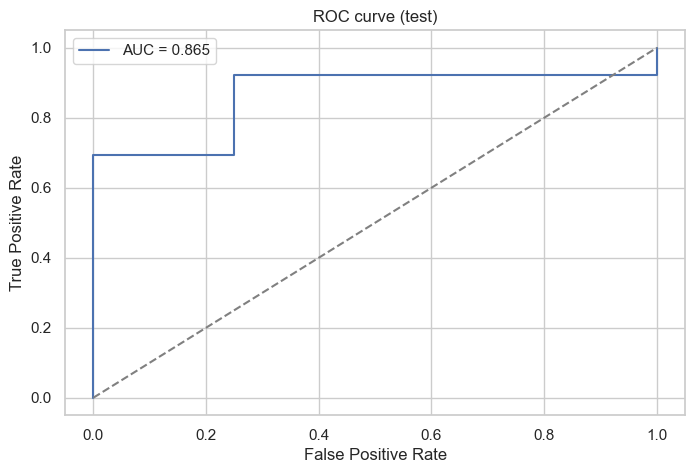

In [14]:
trainFrac = 0.7
doctorTrain = doctorDataFrame.sample(frac=trainFrac, random_state=42)
doctorTest = doctorDataFrame.drop(doctorTrain.index)
print('Train size =', len(doctorTrain), ', Test size =', len(doctorTest))

glmLogitTrain = smf.glm(formula=formula, data=doctorTrain, family=sm.families.Binomial()).fit()
probPredTest = glmLogitTrain.predict(doctorTest)
fpr, tpr, thresholds = roc_curve(doctorTest['y'], probPredTest)
aucScore = roc_auc_score(doctorTest['y'], probPredTest)
print('Test AUC =', aucScore)
plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {aucScore:.3f}')
plt.plot([0,1],[0,1],'--', color='grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve (test)')
plt.legend()
plt.show()


## 13. Stepwise selection по AIC (stepAIC аналог)

Реализуем простую stepwise selection для GLM (добавление/удаление по AIC).

In [15]:
def stepwiseSelectionGLM(dataFrame, response, candidatePredictors, family=sm.families.Binomial(), verbose=True):
    included = []
    while True:
        changed = False
        excluded = [p for p in candidatePredictors if p not in included]
        bestAic = None
        bestToAdd = None

        for newCol in excluded:
            tryPredictors = included + [newCol]
            formulaTry = response + ' ~ ' + ' + '.join(tryPredictors) if tryPredictors else response + ' ~ 1'
            modelTry = smf.glm(formula=formulaTry, data=dataFrame, family=family).fit()
            if bestAic is None or modelTry.aic < bestAic:
                bestAic = modelTry.aic
                bestToAdd = newCol
        
        if bestToAdd is not None:
            formulaCurrent = response + ' ~ ' + ' + '.join(included) if included else response + ' ~ 1'
            modelCurrent = smf.glm(formula=formulaCurrent, data=dataFrame, family=family).fit()
            if bestAic + 1e-8 < modelCurrent.aic:
                included.append(bestToAdd)
                changed = True
                if verbose:
                    print('Add', bestToAdd, 'AIC=', bestAic)

        if included:
            bestAic = None
            worstToRemove = None
            
            for col in included:
                tryPredictors = [c for c in included if c != col]
                formulaTry = response + ' ~ ' + ' + '.join(tryPredictors) if tryPredictors else response + ' ~ 1'
                modelTry = smf.glm(formula=formulaTry, data=dataFrame, family=family).fit()
                if bestAic is None or modelTry.aic < bestAic:
                    bestAic = modelTry.aic
                    worstToRemove = col
            
            modelCurrent = smf.glm(formula=response + ' ~ ' + ' + '.join(included), data=dataFrame, family=family).fit()
            if bestAic + 1e-8 < modelCurrent.aic:
                included.remove(worstToRemove)
                changed = True
                if verbose:
                    print('Remove', worstToRemove, 'improve AIC to', bestAic)
        
        if not changed:
            break
    
    return included

candidatePredictors = []
for term in predictorTerms:
    candidatePredictors.append(term)

selectedPredictors = stepwiseSelectionGLM(doctorDataFrame, 'y', candidatePredictors, family=sm.families.Binomial(), verbose=True)
print('\nSelected predictors by stepwise AIC:', selectedPredictors)


Add x2 AIC= 57.175191077541896
Add x1 AIC= 54.249950080926645
Add x5 AIC= 48.618036591195796

Selected predictors by stepwise AIC: ['x2', 'x1', 'x5']


## 14. Повторный анализ (если stepwise дал другую модель)

Если `selectedPredictors` отличается от исходных, подгоняем новую GLM и повторяем выводы/diagnostics (как выше): коэффициенты, CI, confusionMatrix, ROC и тесты.


In [16]:
if set(selectedPredictors) != set(predictorTerms):
    formulaImproved = 'y ~ ' + ' + '.join(selectedPredictors) if selectedPredictors else 'y ~ 1'
    print('Fitting improved model formula:', formulaImproved)
    glmImproved = smf.glm(formula=formulaImproved, data=doctorDataFrame, family=sm.families.Binomial()).fit()
    print(glmImproved.summary())
else:
    print('Stepwise did not change predictors — оставляем базовую модель.')


Fitting improved model formula: y ~ x2 + x1 + x5
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                   58
Model:                            GLM   Df Residuals:                       54
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -20.309
Date:                Wed, 29 Oct 2025   Deviance:                       40.618
Time:                        23:07:45   Pearson chi2:                     54.2
No. Iterations:                     6   Pseudo R-squ. (CS):             0.4560
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Int

## 15. VIF (мультиколлинеарность) — для числовых предикторов


In [17]:
vifDf = pd.DataFrame()
numericPredictors = [c for c in ['x1','x2','x3','x5'] if c in doctorDataFrame.columns]

dummiesX4 = pd.get_dummies(doctorDataFrame['x4_cat'], prefix='x4')
vifX = pd.concat([doctorDataFrame[numericPredictors].reset_index(drop=True), dummiesX4.reset_index(drop=True)], axis=1)

vifX = vifX.dropna()
vifDf['feature'] = vifX.columns
vifDf['VIF'] = [variance_inflation_factor(vifX.values, i) for i in range(vifX.shape[1])]
print('VIF:')
display(vifDf)


VIF:


,feature,VIF
0,x1,1.206931
1,x2,9.093234
2,x3,9.211444
3,x5,1.095397
4,x4_1.0,11.258123
5,x4_2.0,2.798170
6,x4_3.0,25.238665
